In [1]:
import pandas as pd
%matplotlib inline
import pylab as plt
import numpy as np
import scipy as sc
from scipy import stats

### Incorporating New Dataset

By successfully implementing plans from the last iteration, our dataset has incorporated many new features, such as various AP test scores, general SAT scores, the number of test takers, as well as the distance between each high school and each individual campus. The overall plan is to select the newly added features i.e. various test scores, combining with our old features, and generate a linear regression model to make predictions. First of all, we should take a look of the new dataset. There's quite an amount of NaN's in the test-score fields, so we might need to drop them out if needed.

In [25]:
data = pd.read_csv('data/with_scores.csv')
data.head()

,campus,year,school,school_num,city,county,state,country,region,ethnicity,...,ap_num_scr4,ap_num_scr5,ap_num_test_takers,enroll12,school_name,sat_math_avg,sat_num_test_takers,sat_total_avg,sat_verbal_avg,yield
0,Berkeley,1994.0,ABRAHAM LINCOLN HIGH SCHOOL,3833241.0,Los Angeles,Los Angeles,California,USA,Los Angeles,All,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Berkeley,1994.0,ABRAHAM LINCOLN HIGH SCHOOL,3833241.0,Los Angeles,Los Angeles,California,USA,Los Angeles,Asian,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Berkeley,1994.0,ABRAHAM LINCOLN HIGH SCHOOL,3833241.0,Los Angeles,Los Angeles,California,USA,Los Angeles,Hispanic/ Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Berkeley,1994.0,ABRAHAM LINCOLN HIGH SCHOOL,3833241.0,San Francisco,San Francisco,California,USA,San Francisco,All,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.875
4,Berkeley,1994.0,ABRAHAM LINCOLN HIGH SCHOOL,3833241.0,San Francisco,San Francisco,California,USA,San Francisco,Asian,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.875


check the total number of high schools in our file 

In [3]:
tot_high = len(data['school'].unique())
tot_high

2843

check the number of high schools in California, so that we would get an idea of how much data we are actually dropping off

In [4]:
num_cali_high = len(data[data['state']=='California']['school'].unique())
num_cali_high

860

After checking in the number of the high schools, we would know the actual percentage of Californian high schools as well. By doing that, we know how much data we are sacrifing in order to merge new datasets. 

In [5]:
num_cali_high / tot_high

0.302497361941611

### Filtering out the Non-Californian high schools

Assuming we already have SAT/AP scores and the high schools distances in the file, we would only look for high schools which are in California and we want to filter those schools out first. As a first step, we want to get an idea of how many columns we are dealing with. At the stage, we would take all numerical data into account.

In [6]:
data.columns

Index(['campus', 'year', 'school', 'school_num', 'city', 'county', 'state',
       'country', 'region', 'ethnicity', 'app_num', 'adm_num', 'enr_num',
       'app_gpa', 'adm_gpa', 'enr_gpa', 'distance', 'ap_num_scr1',
       'ap_num_scr2', 'ap_num_scr3', 'ap_num_scr4', 'ap_num_scr5',
       'ap_num_test_takers', 'enroll12', 'school_name', 'sat_math_avg',
       'sat_num_test_takers', 'sat_total_avg', 'sat_verbal_avg', 'yield'],
      dtype='object')

Check the number of available columns 

In [33]:
len(data.columns)

30

We want to exclude extaneous data regarding campus being "Universitywide" since we would later look at each individual campus and check the linear correlations between our predicted yields and the actual yields. Besides, we will take all ethnicities into consideration since "race" is a categorical field. In our last iteration, we did not find anything interesting between "race" and "yield". 

In [27]:
data_cali_high = data[data['state']=='California']
data_cali_high = data_cali_high[data_cali_high['ethnicity']=='All']
data_cali_high = data_cali_high[data_cali_high['campus']!='Universitywide']
data_cali_high.describe()

,year,school_num,app_num,adm_num,enr_num,app_gpa,adm_gpa,enr_gpa,distance,ap_num_scr1,...,ap_num_scr3,ap_num_scr4,ap_num_scr5,ap_num_test_takers,enroll12,sat_math_avg,sat_num_test_takers,sat_total_avg,sat_verbal_avg,yield
count,91169.000000,6.674600e+04,91169.000000,66024.000000,21719.000000,91169.000000,66024.000000,21719.000000,9.114600e+04,49039.000000,...,49034.000000,49018.000000,48957.000000,50400.000000,50940.000000,50169.000000,50430.000000,50169.000000,50169.000000,21719.000000
mean,2007.449254,2.375631e+06,31.341520,18.361338,10.056218,3.655593,3.896412,3.836844,3.546952e+05,89.274516,...,125.056634,100.421437,72.417489,262.971032,415.608049,502.258174,196.472239,982.421930,483.984058,0.382197
std,6.690199,1.558749e+06,35.117882,18.353987,7.109786,0.213359,0.246367,0.270574,2.615003e+05,81.376657,...,110.243613,111.377053,108.810373,196.886720,199.814572,59.758864,116.570493,109.443595,52.680166,0.179135
min,1994.000000,1.002550e+05,5.000000,5.000000,5.000000,2.468333,2.798462,2.782000,6.620000e+02,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,313.023256,1.000000,664.666667,334.000000,0.052632
25%,2002.000000,1.031897e+06,10.000000,7.000000,6.000000,3.515254,3.710000,3.643750,1.133980e+05,34.000000,...,43.000000,26.000000,13.000000,118.000000,266.000000,459.290000,107.000000,902.000000,446.000000,0.250000
50%,2008.000000,1.995448e+06,19.000000,12.000000,8.000000,3.668846,3.926000,3.865714,2.616330e+05,65.000000,...,93.000000,60.000000,33.000000,216.000000,428.000000,505.000000,176.000000,985.333333,485.300000,0.350000
75%,2013.000000,3.631017e+06,38.000000,22.000000,12.000000,3.809412,4.100769,4.054000,6.095810e+05,121.000000,...,176.000000,132.000000,82.000000,362.000000,551.000000,545.000000,263.000000,1060.000000,522.000000,0.484848
max,2017.000000,6.119309e+06,445.000000,310.000000,142.000000,4.356667,4.495000,4.430000,1.348288e+06,695.000000,...,732.000000,796.000000,1045.000000,1486.000000,1166.000000,710.300000,834.000000,1382.600000,672.300000,1.000000


check how many NaN's are there in each field 

In [8]:
count_nan = len(data_cali_high) - data_cali_high.count()
count_nan

campus                     0
year                       0
school                     0
school_num             24423
city                       0
county                     0
state                      0
country                    0
region                     0
ethnicity                  0
app_num                    0
adm_num                25145
enr_num                69450
app_gpa                    0
adm_gpa                25145
enr_gpa                69450
distance                  23
ap_num_scr1            42130
ap_num_scr2            42133
ap_num_scr3            42135
ap_num_scr4            42151
ap_num_scr5            42212
ap_num_test_takers     40769
enroll12               40229
school_name            40229
sat_math_avg           41000
sat_num_test_takers    40739
sat_total_avg          41000
sat_verbal_avg         41000
yield                  69450
dtype: int64

We could filter out the NaN data basically in every column. After that, we would obtain a new dataset which contains all valid entries even though it would only be a very small portion of the original dataset. Furthermore, since our task is to use linear regression function to predict and analyze on each campus, we have to create seprate data frame for individual campus. 

In [31]:
data_cali_high = data_cali_high.dropna()
camp = ['Berkeley', 'Los Angeles', 'Davis', 'Santa Barbara', 'San Diego', 'Santa Cruz', 'Riverside', 'Irvine']
data_cali_high_camp = []
for c in camp:
    data_cali_high_camp.append(data_cali_high[data_cali_high['campus']==c])

data_cali_high.head()
#len(data_cali_high.columns)

,campus,year,school,school_num,city,county,state,country,region,ethnicity,...,ap_num_scr4,ap_num_scr5,ap_num_test_takers,enroll12,school_name,sat_math_avg,sat_num_test_takers,sat_total_avg,sat_verbal_avg,yield
3750,Berkeley,1998.0,ABRAHAM LINCOLN HIGH SCHOOL,3833241.0,San Francisco,San Francisco,California,USA,San Francisco,All,...,23.0,9.0,105.0,415.0,Abraham Lincoln High,521.0,317.0,957.0,436.0,0.833333
3757,Berkeley,1998.0,ACALANES HIGH SCHOOL,730283.0,Lafayette,Contra Costa,California,USA,Contra Costa,All,...,130.0,152.0,242.0,298.0,Acalanes High,596.0,238.0,1180.0,584.0,0.470588
3766,Berkeley,1998.0,ADRIAN C WILCOX HIGH SCHOOL,4338802.0,Santa Clara,Santa Clara,California,USA,Santa Clara,All,...,17.0,14.0,100.0,391.0,Wilcox (Adrian) High,528.0,194.0,1008.0,480.0,0.545455
3769,Berkeley,1998.0,AGOURA HIGH SCHOOL,1930080.0,Agoura Hills,Los Angeles,California,USA,Los Angeles,All,...,62.0,54.0,173.0,407.0,Agoura High,568.0,267.0,1119.0,551.0,0.416667
3773,Berkeley,1998.0,ALAMEDA HIGH SCHOOL,130229.0,Alameda,Alameda,California,USA,Alameda,All,...,54.0,34.0,165.0,372.0,Alameda High,535.0,246.0,1033.0,498.0,0.850000


### Training and Testing

After some processing and cleaning of the dataset, we could begin our training. "train_cols" just contains the names of a number of training features we want to include. For each campus, we would make different training samples. 

In [10]:
train_cols = ['app_num', 'adm_num', 'app_gpa', 'adm_gpa', 'year', 'distance', 
                    'ap_num_scr1', 'ap_num_scr2', 'ap_num_scr3', 'ap_num_scr4', 
                    'ap_num_scr5', 'sat_math_avg', 'sat_verbal_avg', 'sat_total_avg', 
                    'ap_num_test_takers', 'sat_num_test_takers']

train_pred = 'yield'

X_camp, y_camp = [], []

X = data_cali_high[train_cols]
y = data_cali_high[train_pred]

for i in range(0, len(camp)):
    X_camp.append(data_cali_high_camp[i][train_cols])
    y_camp.append(data_cali_high_camp[i][train_pred])

create a function that would evaluate the Z-scores since we don't want to worry about conflicts introduced by different unit systems. 

In [11]:
def z_score(x):
    return (x - x.mean()) / x.std()

The main training process happens here. First of all, the sample has to be split into two parts, we reserve 70% of the data for training, and the rest 30% would be used for testing. We not only do this with all campuses combined, but also with each individual campus by putting them into a list. 

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

X_train_camp, X_test_camp, y_train_camp, y_test_camp = [], [], [], []

for i in range(0, len(camp)):
    X_train_camp.append([])
    X_test_camp.append([])
    y_train_camp.append([])
    y_test_camp.append([])

for i in range(0, len(camp)):
    X_train_camp[i], X_test_camp[i], y_train_camp[i], y_test_camp[i] = \
        train_test_split(X_camp[i], y_camp[i], test_size = 0.3, random_state = 0)

After the splitting process has been done, we need to normalize the training and testing datasets correspondingly.

In [13]:
X_train = z_score(X_train)
y_train = z_score(y_train)
X_test  = z_score(X_test)
y_test  = z_score(y_test)

for i in range(0, len(camp)):
    X_train_camp[i] = z_score(X_train_camp[i])
    y_train_camp[i] = z_score(y_train_camp[i])
    X_test_camp[i]  = z_score(X_test_camp[i])
    y_test_camp[i]  = z_score(y_test_camp[i])

X_test.head()

,app_num,adm_num,app_gpa,adm_gpa,year,distance,ap_num_scr1,ap_num_scr2,ap_num_scr3,ap_num_scr4,ap_num_scr5,sat_math_avg,sat_verbal_avg,sat_total_avg,ap_num_test_takers,sat_num_test_takers
189708,-0.243083,-0.263433,-0.345467,-0.042972,-1.228753,-0.570829,-1.062976,-1.295047,-0.627137,-0.367043,-0.296149,0.552662,0.516796,0.602203,-0.829255,0.330825
94767,-0.613832,-0.498761,1.055688,0.965960,1.154319,1.744894,-0.683702,-0.088415,-0.221595,-0.270181,-0.316453,0.587329,0.714105,0.643418,-0.530473,-0.664659
166100,-0.438214,0.403331,-0.050215,-0.983452,-0.632985,-0.768133,0.300038,1.243434,0.435382,-0.106259,-0.357060,-0.381595,0.090607,-0.115900,0.407244,0.548326
133814,1.142351,-0.224211,1.897919,1.495276,1.154319,-0.274974,-0.363690,1.596317,2.430646,1.570209,0.428016,0.708661,0.901549,0.808281,1.207061,0.238806
46445,1.805798,2.874278,-0.940785,-0.886261,-1.228753,-0.592026,-0.399247,-0.316081,0.256944,0.549426,0.637820,0.604662,0.733836,0.735361,0.545143,1.485253


### Linear Regression

In [14]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
lr = regressor.fit(X_train, y_train)

lr_camp = []

for i in range(0, len(camp)):
    lr_camp.append(regressor.fit(X_train_camp[i], y_train_camp[i]))

In [15]:
coeff_df = pd.DataFrame(regressor.coef_, X.columns, columns = ['coefficient'])

In [16]:
coeff_df

,coefficient
app_num,0.006779
adm_num,-0.020781
app_gpa,0.097631
adm_gpa,-0.235088
year,0.216496
distance,-0.255062
ap_num_scr1,-0.090209
ap_num_scr2,0.045398
ap_num_scr3,0.207893
ap_num_scr4,0.042768


In [17]:
y_pred = lr.predict(X_test)

y_pred_camp = []

for i in range(0, len(camp)):
    y_pred_camp.append(lr_camp[i].predict(X_test_camp[i]))

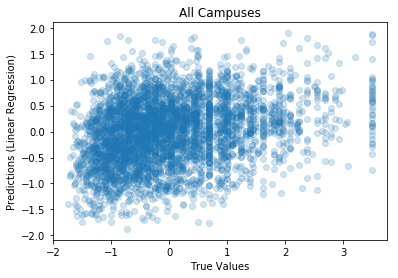

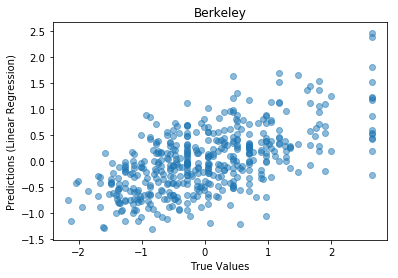

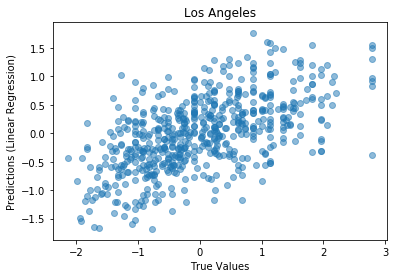

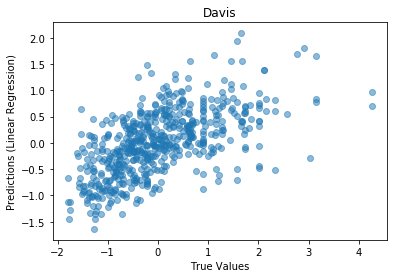

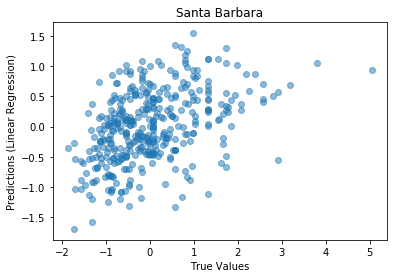

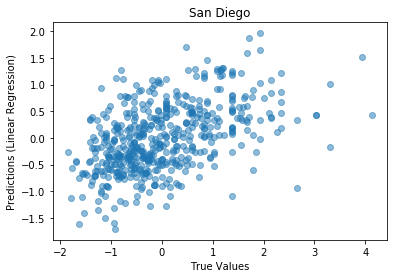

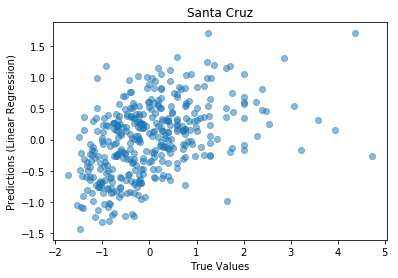

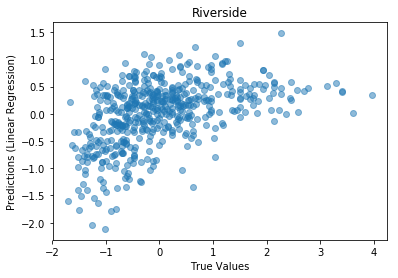

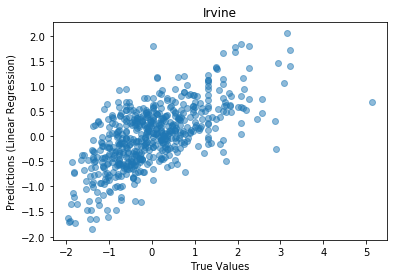

In [18]:
plt.figure(1)
plt.subplot(111)
plt.scatter(y_test, y_pred, alpha=0.2)
plt.xlabel('True Values')
plt.ylabel('Predictions (Linear Regression)')
plt.title('All Campuses')

for i in range(0, len(camp)):
    plt.figure(i+2)
    plt.subplot(111)
    plt.scatter(y_test_camp[i], y_pred_camp[i], alpha=0.5)
    plt.xlabel('True Values')
    plt.ylabel('Predictions (Linear Regression)')
    plt.title(camp[i])

In [19]:
print ('Score for all campuses:', lr.score(X_test, y_test))

for i in range(0, len(camp)):
    print ('Score for', camp[i] , lr.score(X_test_camp[i], y_test_camp[i]))

Score for all campuses: -0.04463883847386607
Score for Berkeley 0.35609597517424896
Score for Los Angeles 0.3312986381386489
Score for Davis 0.3613019154308197
Score for Santa Barbara 0.17324570129378283
Score for San Diego 0.22394577949983696
Score for Santa Cruz 0.1906466252587028
Score for Riverside 0.20798894379049038
Score for Irvine 0.4189693751661755


In [20]:
data_cali_high['year'].unique()

array([1998., 1999., 2000., 2001., 2002., 2003., 2004., 2005., 2006.,
       2007., 2008., 2009., 2010., 2011., 2012., 2013., 2014., 2015.])

### Cross Validation Model. 

Cross Validation is a technique for us to test our model. it involves saving a particular sample of a dataset on which have not trianed on our model yet.

1. we reserve a sample data
2. train the model using the remaining of the datasets 
3. use the reserve sample of the test(validation) dataset. If our model delivers a positive result on the validation data, then we could go ahead with the current model. 

In [21]:
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics

scores = cross_val_score(lr, X, y, cv=10)
print('Cross-validated scores:', scores)

Cross-validated scores: [-0.31384338  0.23521745  0.22150022  0.10327552  0.10004051  0.35362771
 -0.21020602 -0.12829497  0.12025321  0.10481253]


/Users/Nelson/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Text(0,0.5,'Predictions (10-fold cross-validation)')

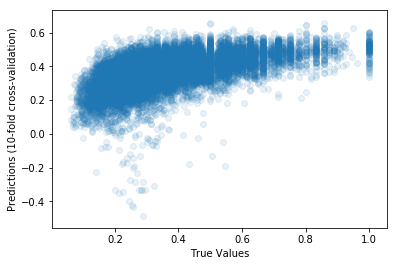

In [22]:
y_cross_pred = cross_val_predict(lr, X, y, cv=10)
plt.scatter(y, y_cross_pred, alpha=0.1)
plt.xlabel('True Values')
plt.ylabel('Predictions (10-fold cross-validation)')

There's much more data points in this plot as there're ten validation samples being trained

In [23]:
cross_accuracy = metrics.r2_score(y, y_cross_pred)
print('Cross-Predicted Accuracy:', cross_accuracy)

Cross-Predicted Accuracy: 0.3020788575526745
